# Wstęp
Zadanie 7 stanowi wprowadzenie w tematykę transfer learning i wykorzystywania gotowych, publicznie udostępnianych modeli. W praktyce, dla zadań tak złożonych jak analiza obrazu, o wiele łatwiej jest dostosować istniejące już i wyuczone na dużych zbiorach danych modele do nowego zaadania, niż wyuczyć własny model od zera. Jako bardziej interesujący przykład zastosowania gotowych modeli zostanie pokazany też transfer stylu obrazów.

# Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    mechanizmem importowania modeli
*    możliwościami wykorzystaniem transfer learningu do własnych zadań
*    transferem stylu jako przykładem wykorzystania cech z zamrożonej architektury

# Importowanie modeli

Importowanie w torchu realizować będziemy poprzez ładowanie zapisanego obiektu słownika z wszystkimi parametrami warstw. Warto pamiętać tutaj, że słownik ten nie zapamiętuje pełnej struktury sieci, a jedynie parametry! Dlatego z jednej strony dla wczytania gotowego modelu konieczne jest istnienie odpowiedniej architektury w kodzie (zaimplementowany `torch.nn.Module` realizujący tę architekturę). Z drugiej zaś, słownik parametrów zgodny pod względem nazw i kształtów parametrów z zadaną architekturą możemy wczytać do dowolnej, dostosowanej do naszych potrzeb klasy - w szczególności umożliwiając nam własną implementację `forward`. Na razie sprawdźmy model, który ma już swoją implementację w `torchvision`: klasyczną architekturę VGG.

In [1]:
import torch
import torchvision.models as models
from matplotlib import pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

vgg19 = models.vgg19(pretrained=True)

print(vgg19)

Using device: mps


/opt/miniconda3/envs/pytorch310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/pytorch310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [2]:
def plot_results(results):
    num_rows = len(results)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * len(results)))
    if num_rows == 1:
        axes = [axes]
    for ax, (key, values) in zip(axes, results.items()):

        epochs = range(1, len(values['train_loss']) + 1)

        ax[0].plot(epochs, [x for x in values['train_loss']], label='Train Loss')
        ax[0].plot(epochs, [x for x in values['test_loss']], label='Test Loss')
        ax[0].set_title(f"{key} Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].plot(epochs, [x for x in values['train_acc']], label='Train Accuracy')
        ax[1].plot(epochs, [x for x in values['test_acc']], label='Test Accuracy')
        ax[1].set_title(f"{key} Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

    plt.tight_layout()
    plt.show()

W kontekście vgg19, interesuje nas szczególnie moduł features: instancja `torch.nn.Sequential', obejmująca konwolucyjną część architektury. Dla nowych zadań analizy obrazów, możemy wykorzystać tę częśc z własnym klassyfikatorem.

In [3]:
print(vgg19.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Tutaj warto zwrócić jeszcze uwagę na przydatną własność `torch.nn.Sequential`: ta klasa jest indeksowalna, a kiedy korzystamy z indeksowania aby zwócić ciąg następujących po sobie elementów, zwracana jest również instancja `torch.nn.Sequential`:

In [4]:
print(f"pod indeksem 3 jest: {vgg19.features[3]}")
print(f"pod indeksami 3 do 7 jest: {vgg19.features[3:7]}")

pod indeksem 3 jest: ReLU(inplace=True)
pod indeksami 3 do 7 jest: Sequential(
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
)


# Zadanie 1

Zdefiniuj klasę LabVGG19, która inicjalizuje swoje parametry poprzez wczytanie wyuczonego modelu z torchvision.models, ale jej `forward` zwraca na wyjściu krotkę lub listę `out` gdzie



*   `out[0]` - cechy z poziomu architektury poprzedzającego pierwszy Max Pooling
*    `out[1]` - cechy z poziomu architektury poprzedzającego drugi Max Pooling
*    `out[2]` - cechy z poziomu architektury poprzedzającego trzeci Max Pooling


In [5]:
class LabVGG19(torch.nn.Module):
    def __init__(self):
        super(LabVGG19, self).__init__()
        vgg_pretrained = models.vgg19(pretrained=True)
        features = vgg_pretrained.features
        
        self.features_part1 = torch.nn.Sequential(*features[:4])
        self.features_part2 = torch.nn.Sequential(*features[:9])
        self.features_part3 = torch.nn.Sequential(*features[:18])

    def forward(self, x):
        out1 = self.features_part1(x)
        out2 = self.features_part2(x)
        out3 = self.features_part3(x)
        return out1, out2, out3

Zweryfikuj działanie architektury

In [6]:
model = LabVGG19()
dummy_input = torch.zeros((3,3,32,32))
out = model(dummy_input)
print(f'Output shapes: {[o.shape for o in out]}')


assert(out[0].shape == (3,64,32,32))
assert(out[1].shape == (3,128,16,16))
assert(out[2].shape == (3,256,8,8))

Output shapes: [torch.Size([3, 64, 32, 32]), torch.Size([3, 128, 16, 16]), torch.Size([3, 256, 8, 8])]


# Transfer Learning

Mając możliwość wydobywania cech z dowolnego poziomu architektury, możemy łatwo wykorzystać je do dowolnych nowych zadań. Wystarczy zbudować model, który przetwarza jako wejście to, co wynika z naszego wcześniejszego przetwarzania przez wyuczoną już sieć. Zaimportowaną część sieci możemy zarówno **douczać** jak i **zamrozić** w zależności od tego czy jej parametry podamy przy naszym uczeniu do optymalizowania. W tym drugim przypadku, warto pamiętać o wyłączeniu gradientów dla zamrożonych warstw.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.


**VGG na wejściu oczekuje danych znormalizowanych, z określonymi wartościami średniej i odchylenia standardowego. Transformacja wejściowa powinna korzystać z `transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))`.**

In [7]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.to(device))
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.to(device)).sum()
        correct += count_correct(y_pred, y_batch.to(device))
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.to(device))
          loss = loss_fn(y_pred, y_batch.to(device))

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 2

Zaimplementuj model korzystający z cech wyjściowych na pierwszym, drugim i trzecim poziomie zwracanym przez LabVGG19. (Wykorzystaj Adaptive Pooling aby uniknąć gigantycznej wymiarowości wynikającej ze spłaszczania na tych poziomach). Porównaj wyniki tego modelu na CIFAR10 w wariantach: zamrożonych warstw konwolucyjnych i z douczaniem warstw konwolucyjnych.

Uwaga: zadania 2 i 3 będą wymagały więcej czasu przetwarzania niż wysiłku intelektualnego, więc polecane jest wykonanie ich jako ostatnich, a na zajęciach - przejście do punktu Transfer Stylu.

In [8]:
class CustomVGGClassifier(nn.Module):
    def __init__(self, vgg_model, num_classes=10, frozen = False):
        super(CustomVGGClassifier, self).__init__()
        self.features = vgg_model

        if frozen:
            for param in self.features.parameters():
                param.requires_grad = False
        else:
            for param in self.features.parameters():
                param.requires_grad = True

        # Adaptacyjne Poolingi do redukcji wymiarów
        self.adaptive_pool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.adaptive_pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.adaptive_pool3 = nn.AdaptiveAvgPool2d((1, 1))

        # Klasyfikator
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 + 128 + 256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out1, out2, out3 = self.features(x)
        out1 = self.adaptive_pool1(out1)
        out2 = self.adaptive_pool2(out2)
        out3 = self.adaptive_pool3(out3)
        concatenated_features = torch.cat((out1, out2, out3), dim=1)
        return self.classifier(concatenated_features)

# Użycie CustomVGGClassifier
vgg_base = LabVGG19()
model = CustomVGGClassifier(vgg_base)

# Przygotowanie do treningu
model = model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Trening i testowanie modelu
# fit(model, optimizer, loss_fn, train_dl, test_dl, epochs=10)

Epoch 0: train loss = 1.095 (acc: 0.614), test loss = 0.809 (acc: 0.723)
Epoch 1: train loss = 0.924 (acc: 0.674), test loss = 0.808 (acc: 0.709)
Epoch 2: train loss = 0.872 (acc: 0.696), test loss = 0.716 (acc: 0.754)
Epoch 3: train loss = 0.838 (acc: 0.708), test loss = 0.696 (acc: 0.763)
Epoch 4: train loss = 0.819 (acc: 0.714), test loss = 0.686 (acc: 0.762)
Epoch 5: train loss = 0.804 (acc: 0.719), test loss = 0.701 (acc: 0.759)
Epoch 6: train loss = 0.792 (acc: 0.723), test loss = 0.708 (acc: 0.754)
Epoch 7: train loss = 0.774 (acc: 0.731), test loss = 0.665 (acc: 0.770)
Epoch 8: train loss = 0.765 (acc: 0.736), test loss = 0.654 (acc: 0.772)
Epoch 9: train loss = 0.758 (acc: 0.738), test loss = 0.720 (acc: 0.747)
Epoch 0: train loss = 1.069 (acc: 0.615), test loss = 0.718 (acc: 0.763)
Epoch 1: train loss = 0.612 (acc: 0.796), test loss = 0.562 (acc: 0.804)
Epoch 2: train loss = 0.472 (acc: 0.844), test loss = 0.576 (acc: 0.817)
Epoch 3: train loss = 0.380 (acc: 0.873), test loss

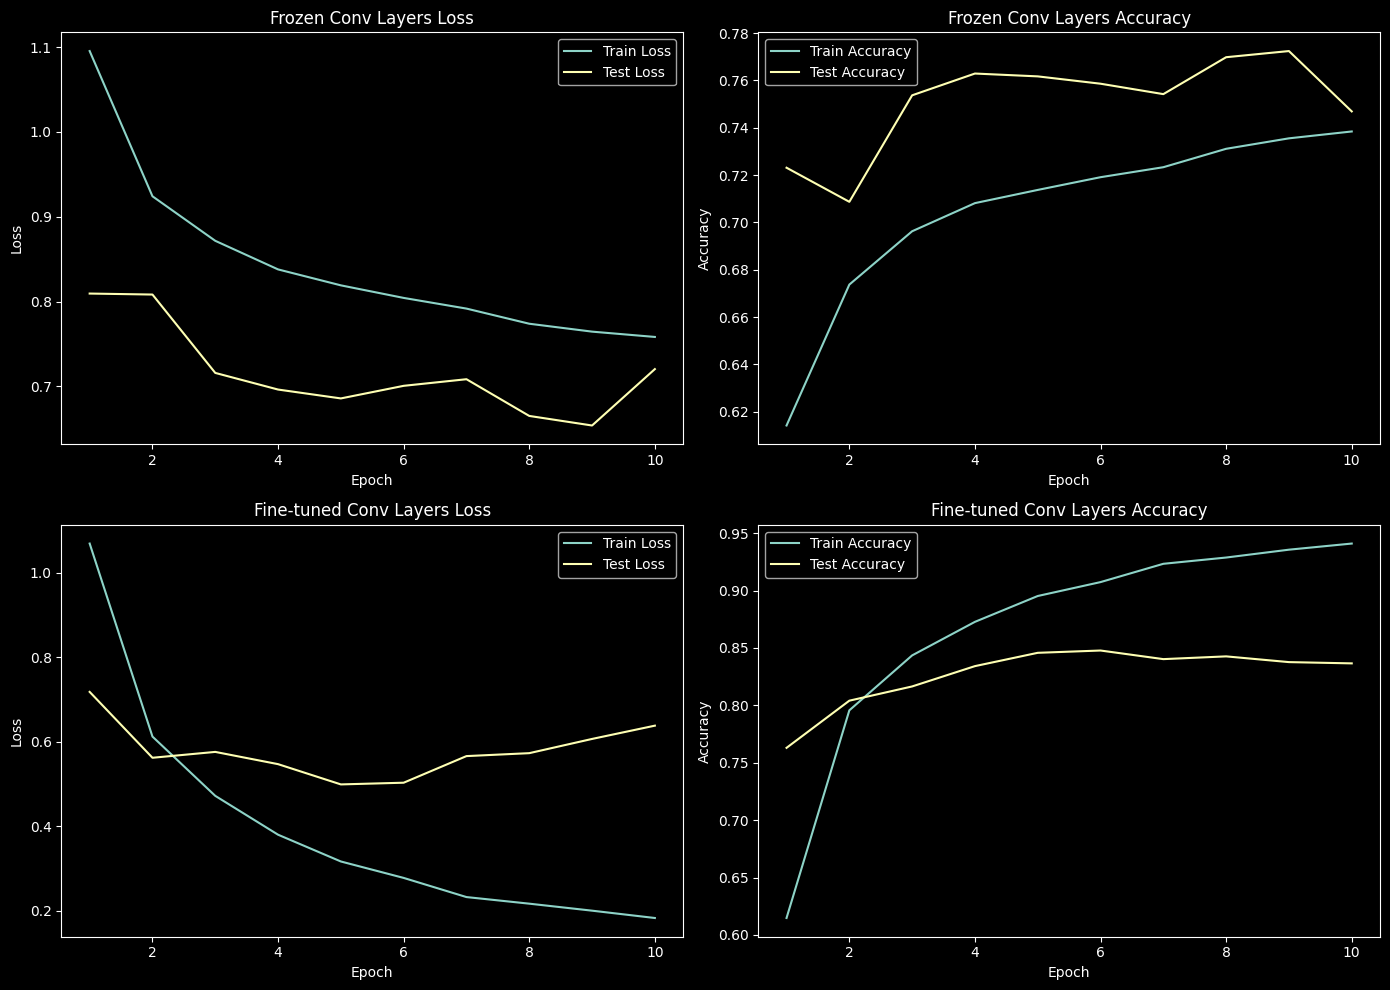

In [9]:
def train_and_evaluate(model, optimizer, loss_fn, train_dl, val_dl, epochs):
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)
            correct += (y_pred.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_loss = epoch_train_loss / total

        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0
            correct = 0
            total = 0

            for X_batch, y_batch in val_dl:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                epoch_val_loss += loss.item() * X_batch.size(0)
                correct += (y_pred.argmax(1) == y_batch).sum().item()
                total += y_batch.size(0)

            val_acc = correct / total
            val_loss = epoch_val_loss / total
            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            metrics['test_loss'].append(val_loss)
            metrics['test_acc'].append(val_acc)
            print(
                f"Epoch {epoch}: "
                f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                f"test loss = {val_loss:.3f} (acc: {val_acc:.3f})"
            )

    return metrics

# Create the model instance and freeze layers
vgg_base_frozen = LabVGG19()
frozen_model = CustomVGGClassifier(vgg_base_frozen, frozen=True)
frozen_model.to(device)
results = {}

# Train with frozen conv layers
frozen_optimizer = optim.Adam(frozen_model.classifier.parameters(), lr=0.001)
results['Frozen Conv Layers'] = train_and_evaluate(frozen_model, frozen_optimizer, loss_fn, train_dl, test_dl, 10)

# Create the model instance for fine-tuning
vgg_base_finetune = LabVGG19()
# Enable training on all parameters
for param in vgg_base_finetune.parameters():
    param.requires_grad = True

finetune_model = CustomVGGClassifier(vgg_base_finetune, frozen=False)
finetune_model.to(device)

# Train with fine-tuning
finetune_optimizer = optim.Adam(finetune_model.parameters(), lr=0.001)
results['Fine-tuned Conv Layers'] = train_and_evaluate(finetune_model, finetune_optimizer, loss_fn, train_dl, test_dl, 10)
plot_results(results)

# Zadanie 3

Spróbuj wydobyć cechy za pomocą samodzielmnie wybranego modelu dostępnego w `torchvision.models` (innego niż VGG) a następnie wyuczyć model MLP oparty o cechy na wyjściu konwolucyjnej części całej architektury. Porównaj wynik z tymi, które uzyskała sieć oparta o LabVGG19.

/opt/miniconda3/envs/pytorch310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: train loss = 1.207 (acc: 0.609), test loss = 0.882 (acc: 0.701)
Epoch 1: train loss = 0.885 (acc: 0.719), test loss = 0.806 (acc: 0.732)
Epoch 2: train loss = 0.737 (acc: 0.770), test loss = 0.687 (acc: 0.775)
Epoch 3: train loss = 0.609 (acc: 0.810), test loss = 0.651 (acc: 0.785)
Epoch 4: train loss = 0.518 (acc: 0.836), test loss = 0.638 (acc: 0.795)
Epoch 5: train loss = 0.442 (acc: 0.860), test loss = 0.634 (acc: 0.804)
Epoch 6: train loss = 0.379 (acc: 0.881), test loss = 0.659 (acc: 0.801)
Epoch 7: train loss = 0.318 (acc: 0.899), test loss = 0.628 (acc: 0.803)
Epoch 8: train loss = 0.265 (acc: 0.917), test loss = 0.713 (acc: 0.788)
Epoch 9: train loss = 0.223 (acc: 0.930), test loss = 0.719 (acc: 0.800)


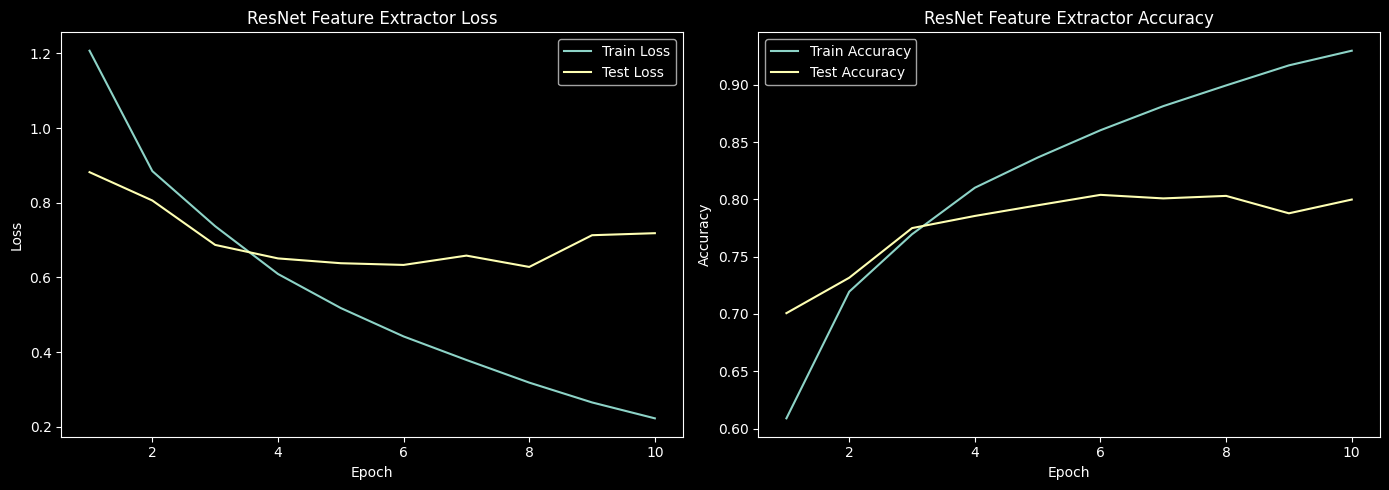

In [10]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True, num_classes=10):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last linear layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),  # 512 is the number of features from ResNet18's avgpool
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

results = {}
resnet_model = ResNetFeatureExtractor()
resnet_model.to(device)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
results['ResNet Feature Extractor'] = train_and_evaluate(resnet_model, optimizer, loss_fn, train_dl, test_dl, 10)
plot_results(results)


# Transfer stylu

Jedną z ciekawszych demonstracji tego, jak wykorzystać można cechy wyciągane z gotowego modelu jest tzw. transfer stylu - jedno z klasycznych "pokazowych" zastosowań głębokiego uczenia. Tutaj spróbujemy najprostszego podejścia, o wąskiej definicji stylu obejmującej właściwości tekstury obrazu. Bardziej zaawansowane opcje obejmują zastosowania sieci GAN, czy deformacje kształtu oparte o punkty kluczowe, a to już materiał na inny kurs.

Transfer stylu opisany został w roku 2015, w publikacji *A Neural Algorithm of Artistic Style*

https://arxiv.org/abs/1508.06576

To oryginalne, najbardziej klasyczne podejście opiera się optymalizację w przestrzeni obrazu. Parametrem nie jest tutaj sieć, ale właśnie obrazek który próbujemy stworzyć. Dla zadanego obrazka definiującego treść i obrazka definiującego styl skorzystamy z cech zwróconych przez sieć VGG, aby obliczyć dwie funkcje kosztu - koszt treści i stylu. Następnie będziemy optymalizować generowany obraz tak, aby zminimalizować koszt treści względem obrazu określającego pożądaną treść, oraz zminimalizować koszt stylu względem obrazu określającego pożądany styl. Efektem, jeśli wszystko się uda, będzie nowe dzieło, przedstawiające treść obrazka pierwszego *w stylu* obrazka drugiego.

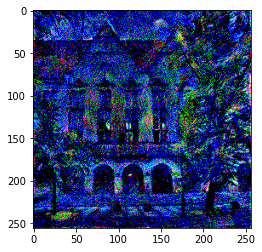

Jak zdefiniować koszt treści? Tutaj rozwiązanie jest proste - błąd średniokwadratowy pomiędzy cechami zwróconymi przez VGG z obrazu docelowego, a tymi zwróconymi z obrazu optymalizowanego. Chcemy żeby nasz obrazek zawierał tę samą treść, a więc oczekujemy, że jego cechy wykrywane przez wyuczony na zadaniu rozpoznawania obiektów model będą podobne.




In [11]:
import torch.nn.functional as F

def content_loss(content_features, input_features):
  return F.mse_loss(content_features, input_features)

Styl/tekstura to trochę bardziej skomplikowane pojęcie. W tym przypadku będziemy o nim myśleć w kategorii rozkładu cech występujących na całej powierzchni obrazu, niezależnie od położenia. Autorzy klasycznego podejścia wybrali jako matematyczny obiekt opisujący ten rozkład macierz Grama:

https://en.wikipedia.org/wiki/Gramian_matrix

Macierz taka jest własnością pewnego zbioru wektorów i aby przybliżyć jej definicję, zamiast korzystać ze wzorów spójrzmy po prostu na implementację:

In [12]:
def calculate_gram_matrices(feature_tensor):
  # zakładamy paczkę map cech na wejściu - a to wymiar batcha
  a,b,c,d = feature_tensor.shape
  reshaped_features = feature_tensor.view(a,b,c*d)
  # wyjście ma wymiar (a,b,b) - jest paczką macierzy
  return torch.matmul(reshaped_features, reshaped_features.transpose(1,2))

Powyższy kod zwraca dla batcha wejściowego, batch macierzy Grama. Możemy myśleć o macierzy Grama jako o obiekcie powiązanym z *macierzą kowariancji* rozkładu cech. Istotne różnice: wektory przy wyliczaniu macierzy Grama nie są przesunięte o średnią, zaś wynik nie jest dzielony przez liczbę punktów, więc nie jest to wartość oczekiwana. To ta druga różnica sprawia, że mówimy o własności *zbioru wektorów* zamiast o własności *rozkładu* - bo elementy macierzy Grama będą zwiększać się z większą liczbą uwzględnionych punktów.
(Naszym zbiorem będzie w tym przypadku *zbiór wszystkich pikseli w danej mapie cech*.) Jeżeli jednak wykorzystujemy obrazy treści i stylu o tym samym rozmiarze co rozmiar obrazu generowanego, ta różnica staje się pomijalna.

Stąd łatwo już przejść do definicji kosztu: kosztem stylu będzie błąd średniokwadratowy pomiędzy macierzami grama opisującymi odpowiednie mapy cech:



In [13]:
def style_loss(style_features, input_features):
  return F.mse_loss(calculate_gram_matrices(style_features), calculate_gram_matrices(input_features))

Pozostaje pytanie, na jakim poziomie wyciągać z architektury cechy? Tutaj jednoznacznej odpowiedzi nie ma, acz typowo stylu szukać będziemy na niższych poziomach, niż treści. W praktyce jednak najlepsze wyniki osiągniemy, próbując dopasować rozwiązanie do konkretnej pary obrazów styl/treść i konkrentej rozdzielczości.

Jescze jedna uwaga na koniec: zauważ, że transfer stylu jest dobrym przykladem zadania gdzie **zawsze** będziemy zamrażać architekturę wydobywającą cechy. Dlaczego? Douczanie ekstraktora cech ułatwiałoby osiągnięcie optimum funkcji kosztu (patrząc na samą wartość). Ale w żaden sposób nie zapewnialibyśmy przy tym, że wydobywane cechy dalej mają coś wspólnego z semantycznymi cechami obrazu. Globalnym optimum w przestrzeni parametrów: obrazu i sieci, byłby ekstraktor który niezależnie od wejścia, zeruje wartości wszystkich cech!

# Zadanie 4

Zaimplementuj transfer stylu, wykorzystując LabVGG19 aby otrzymać cechy na różnych poziomach architektury. Algorytm transferu stylu powinien wykonywać `num_steps` kroków optymalizatora LBFGS, optymalizującego obrazek `input_img` względem kosztów stylu i treści. Koszty stylu i treści powinny być wyliczane na wybieranym parametrem poziomie architektury. Po zakończeniu wyświetl wygenerowany obraz.

Pamiętając, że koszty: stylu i treści można wyliczac na różnych poziomach architektury oraz z różnymi wagami, spróbuj dopasować te aspekty algorytmu aby uzyskać interesujący wizualnie efekt.

Run:  0
Total loss:  22652561408.0
Run:  100
Total loss:  28459339776.0
Run:  200
Total loss:  28459339776.0


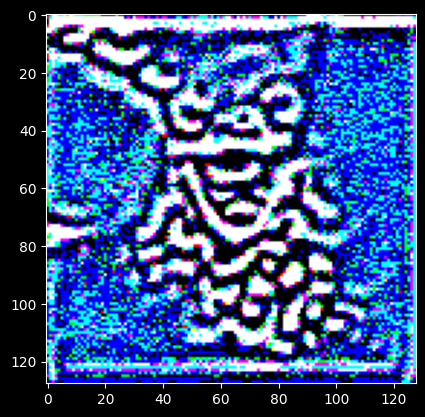

In [31]:
from PIL import Image
import torch.optim as optim

def image_loader(image_name, imsize):
    image = Image.open(image_name)
    loader = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def total_variation_loss(img):
    # Obliczanie różnic między sąsiednimi pikselami
    tv_loss = torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
              torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return tv_loss


def style_transfer(content_img, style_img, input_img, model, num_steps=300, style_weight=1000, content_weight=1):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    tv_weight = 1e-6
    for i in range(num_steps):
        def closure():
            input_img.data.clamp_(0, 1)  # Correct the values of updated input image to be between 0 and 1
            optimizer.zero_grad()

            model.eval()
            content_features = model(content_img)[1]  # Adjust index for appropriate content layer
            style_features = model(style_img)[0]  # Adjust index for appropriate style layer
            input_features = model(input_img)

            content_loss_val = content_loss(content_features, input_features[1])
            style_loss_val = style_loss(style_features, input_features[0])

            # total_loss = content_weight * content_loss_val + style_weight * style_loss_val
            tv_loss_val = total_variation_loss(input_img)

            # Inicjalizacja total_loss wewnątrz closure
            total_loss = content_weight * content_loss_val + style_weight * style_loss_val + tv_weight * tv_loss_val
            total_loss.backward()

            return total_loss

        total_loss = optimizer.step(closure)

        # print every 100 steps
        if i % 100 == 0:
            print("Run: ", i)
            print('Total loss: ', total_loss.item())

    input_img.data.clamp_(0, 1)
    return input_img

imsize = (128,128)
# imsize = (512,512)
style_img = image_loader("imgs/starry_night.jpeg", imsize).to(device)
content_img = image_loader("imgs/frog.jpg", imsize).to(device)
input_img = content_img.clone()

vgg_model = LabVGG19().to(device).eval()
output = style_transfer(content_img, style_img, input_img, vgg_model, num_steps=300)

def tensor_to_image(tensor):
    tensor = tensor.cpu().clone()
    tensor = tensor.squeeze(0)
    tensor = transforms.ToPILImage()(tensor)
    return tensor

resulting_image = tensor_to_image(output)

plt.figure()
plt.imshow(resulting_image)
sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [15]:
# def run_style_transfer(content_img, style_img, input_img, model, num_steps=300, style_weight=10, content_weight=10):
#     """Run the style transfer."""
#     print('Building the style transfer model..')
#     model.eval()
#     optimizer = optim.LBFGS([input_img.requires_grad_()])

#     run = [0]
#     while run[0] <= num_steps:

#         def closure():
#             # correct the values of updated input image
#             input_img.data.clamp_(0, 1)

#             optimizer.zero_grad()
#             model(input_img)
#             style_score = 0
#             content_score = 0

#             content_features = model(content_img)
#             style_features = model(style_img)
#             input_features = model(input_img)

#             content_loss_val = content_loss(content_features[2], input_features[2])
#             style_loss_val = style_loss(style_features[0], input_features[0])

#             style_score += style_loss_val * style_weight
#             content_score += content_loss_val * content_weight

#             loss = style_score + content_score
#             loss.backward()

#             run[0] += 1
#             if run[0] % 50 == 0:
#                 print("run {}:".format(run))
#                 print('Style Loss : {:4f} Content Loss: {:4f}'.format(
#                     style_score.item(), content_score.item()))
#                 print()

#             return style_score + content_score

#         optimizer.step(closure)

#     input_img.data.clamp_(0, 1)

#     return input_img

# imsize = (128,128)
# # imsize = (512,512)

# style_img = image_loader("imgs/dune_fight.jpeg", imsize)
# content_img = image_loader("imgs/frog.jpg", imsize)

# # Inicjalizacja modelu VGG
# vgg_model = LabVGG19().to(device)

# # Inicjalizacja obrazu wejściowego
# input_img = content_img.clone()

# # Uruchomienie transferu stylu
# output = run_style_transfer(content_img, style_img, input_img, vgg_model)
# output_img = output[0].cpu().detach().numpy().transpose(1,2,0)

# plt.figure()
# plt.imshow(output_img)
# sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.show()

In [16]:

# plt.imsave("output.jpg", output_img)

Run:  0
Total loss:  2265256.75
Run:  100
Total loss:  4128448.25
Run:  200
Total loss:  4128448.25
Run:  0
Total loss:  2265258.25
Run:  100
Total loss:  nan
Run:  200
Total loss:  nan
Run:  0
Total loss:  2265260.0
Run:  100
Total loss:  2255816.75
Run:  200
Total loss:  2255816.75
Run:  0
Total loss:  2265295.0
Run:  100
Total loss:  3182387.25
Run:  200
Total loss:  3182387.25
Run:  0
Total loss:  2265643.5
Run:  100
Total loss:  3267321.25
Run:  200
Total loss:  3267321.25
Run:  0
Total loss:  2303983.25
Run:  100
Total loss:  nan
Run:  200
Total loss:  nan
Run:  0
Total loss:  40992200.0
Run:  100
Total loss:  nan
Run:  200
Total loss:  nan
Run:  0
Total loss:  11326281.0
Run:  100
Total loss:  19431976.0
Run:  200
Total loss:  19431976.0
Run:  0
Total loss:  11326283.0
Run:  100
Total loss:  13060792.0
Run:  200
Total loss:  13060792.0
Run:  0
Total loss:  11326285.0
Run:  100
Total loss:  nan
Run:  200
Total loss:  nan
Run:  0
Total loss:  11326320.0
Run:  100
Total loss:  nan


/opt/miniconda3/envs/pytorch310/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


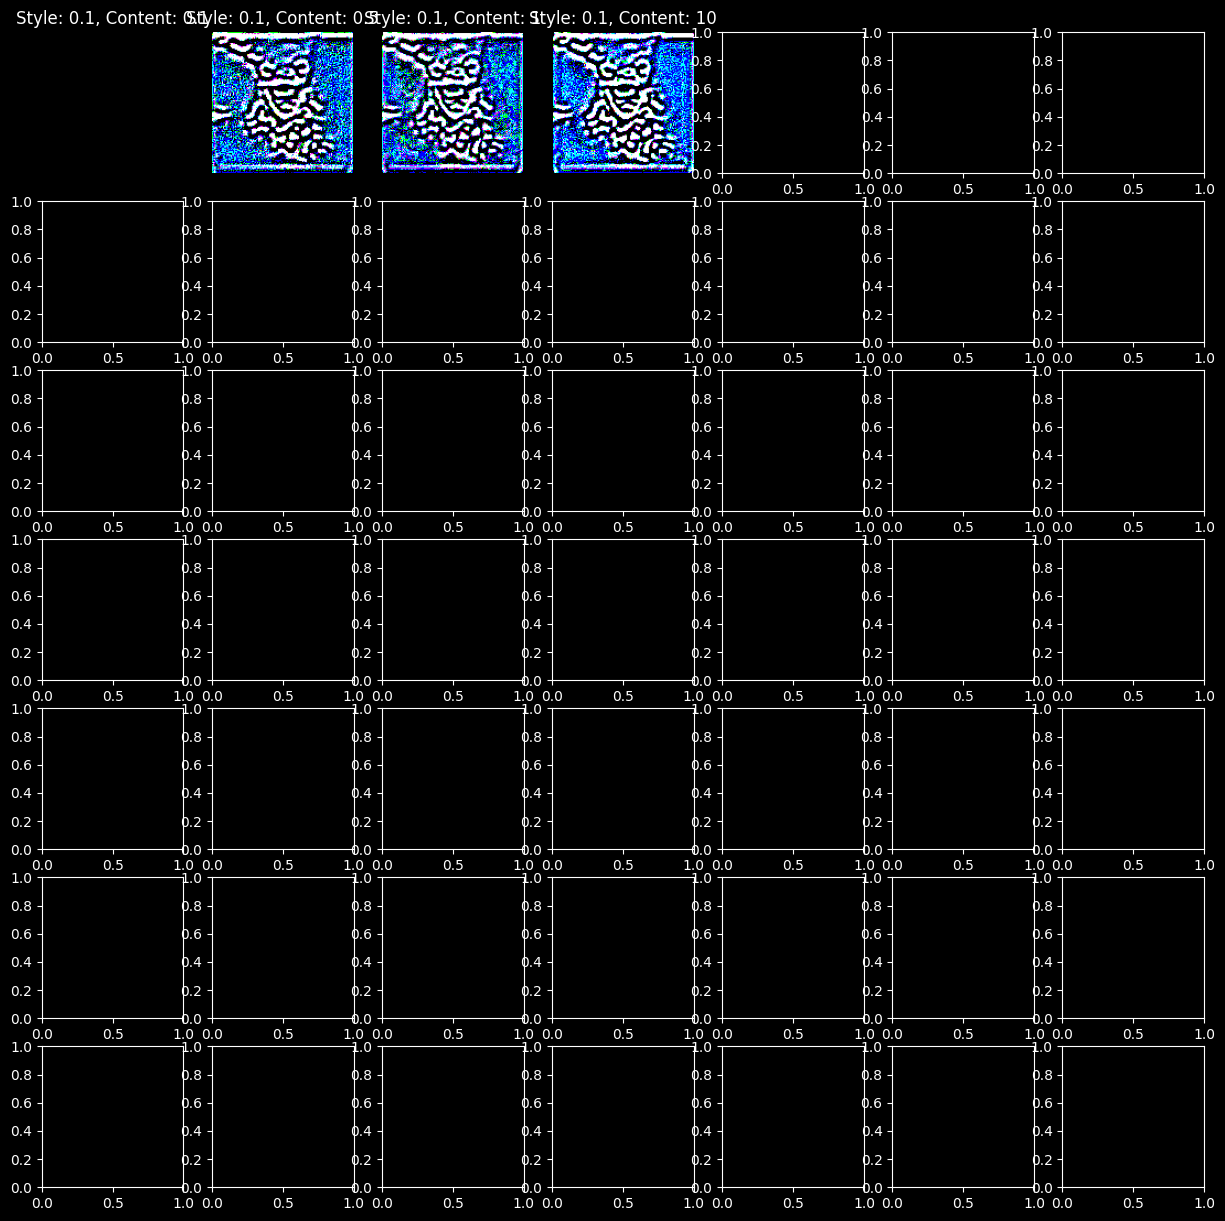

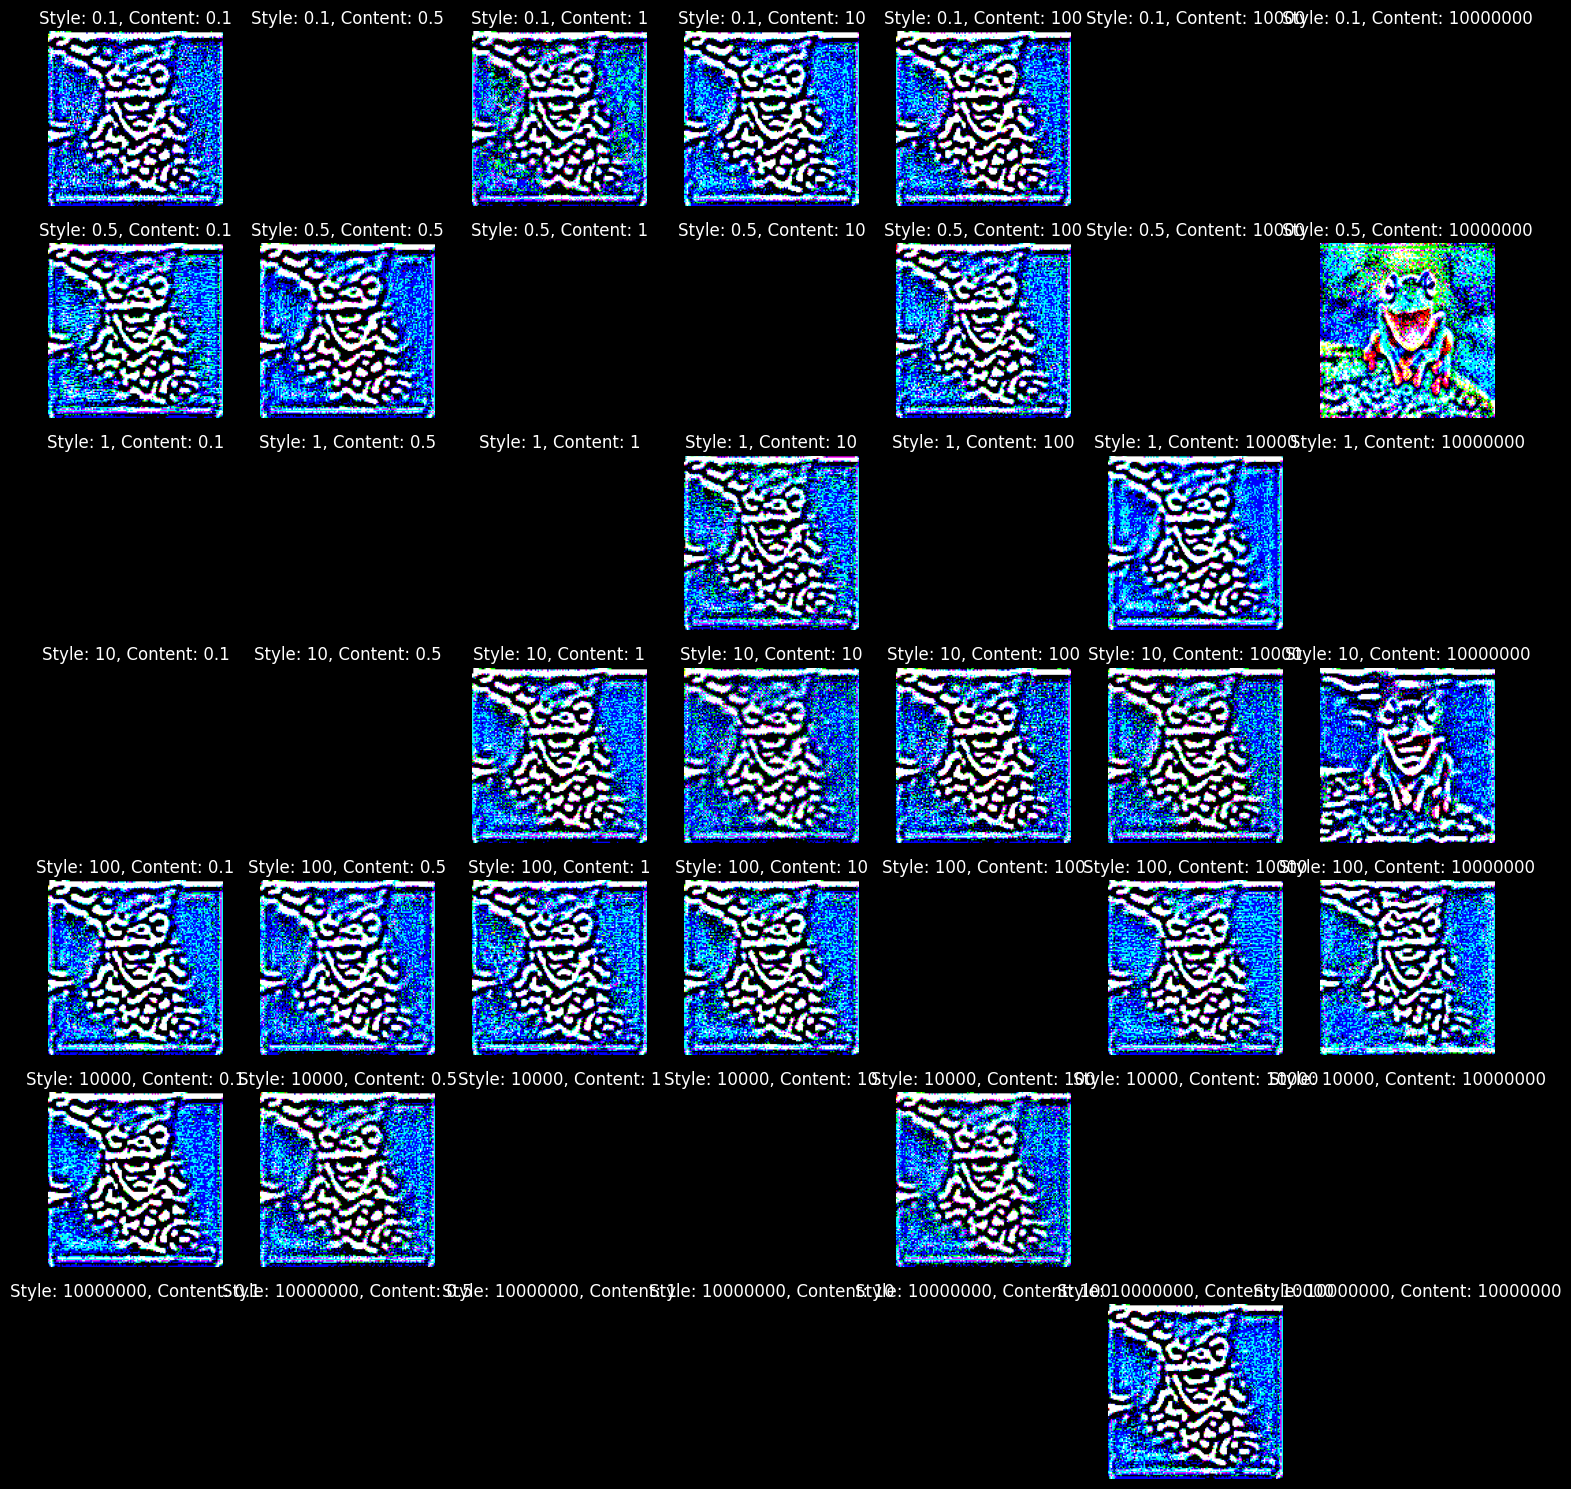

In [33]:
import numpy as np

# Definicja wag
style_weights = [0.1, 0.5, 1, 10, 100, 10000, 10000000]
content_weights = [0.1, 0.5, 1, 10, 100, 10000, 10000000]

# Wczytanie obrazów
imsize = (128, 128)

style_img = image_loader("imgs/hannna.jpeg", imsize).to(device)
content_img = image_loader("imgs/frog.jpg", imsize).to(device)


# Inicjalizacja modelu
vgg_model = LabVGG19().to(device)

# Przygotowanie siatki do wyświetlania wyników
fig, axs = plt.subplots(len(style_weights), len(content_weights), figsize=(15, 15))

for i, style_weight in enumerate(style_weights):
    for j, content_weight in enumerate(content_weights):
        # Inicjalizacja obrazu wejściowego
        input_img = content_img.clone()
        
        # Uruchomienie transferu stylu
        output = style_transfer(content_img, style_img, input_img, vgg_model, num_steps=300, style_weight=style_weight, content_weight=content_weight)
        output_img = output.cpu().detach().numpy().squeeze().transpose(1, 2, 0)
        output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min())  # Normalizacja do zakresu [0, 1]

        # Wyświetlenie obrazu
        ax = axs[i, j]
        ax.imshow(output_img)
        ax.axis('off')
        ax.set_title(f"Style: {style_weight}, Content: {content_weight}")

plt.tight_layout()
plt.show()

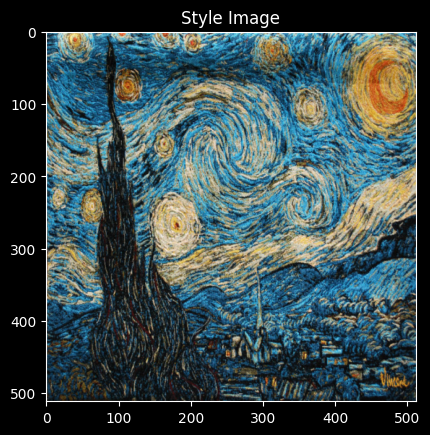

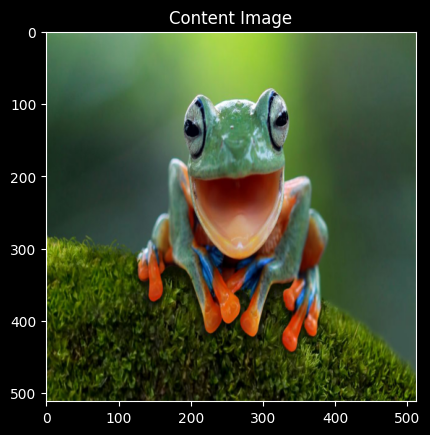

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

torch.set_default_device(device)


imsize =  512 

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    # change the size of an image to 512x512
    image = F.interpolate(image, size=(512, 512), mode='bilinear', align_corners=False)

    return image.to(device, torch.float)

style_img = image_loader("imgs/starry_night.jpg")
content_img = image_loader("imgs/frog.jpg")
# style_img = image_loader("imgs/autko.jpeg")
# content_img = image_loader("imgs/oczko.jpeg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"


unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


cnn = LabVGG19().to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std
    

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [95]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [96]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..


RuntimeError: Unrecognized layer: Sequential